### 05 - Inference yoga pose detection

In [50]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from PIL import Image

#### Stap 1. Video inladen

In [73]:
file = 'C:\\Users\\joost.vanstreels\\PycharmProjects\\YOLOv8\\runs\\DATASET HM\\INFERENCE\\Video Shanna.mp4'
file

'C:\\Users\\joost.vanstreels\\PycharmProjects\\YOLOv8\\runs\\DATASET HM\\INFERENCE\\Video Shanna.mp4'

#### Stap 2. Keypoints genereren met YOLO

In [74]:
# Keuze uit verschillende modellen
model = YOLO('yolov8m-pose.pt')
#model = YOLO('yolov8n-pose.pt')

In [75]:
results_inference = model.predict(file, save=True, vid_stride=5, conf=0.5)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/270) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video Shanna.mp4: 640x384 1 person, 1218.0ms
video 1/1 (2/270) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video Shanna.mp4: 640x384 1 person, 1653.0ms
video 1/1 (3/270) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video Shanna.mp4: 640x384 1 person, 2307.4ms
video 1/1 (4/270) C:\Users\joost.vanstreels\

#### Stap 3. Data postprocessing


In [76]:
# Image source, 17x2 keypoints, 17 confidences per keypoint opslaan in array
analytics_data = np.empty([1, 53])
i = 0
for r in results_inference:
    # De has_visible check controleert of er een persoon gedetecteerd is
    if r.keypoints.has_visible == True:
        frame_number = np.array([[i]])
        confidence = np.array([r.__getitem__(0).boxes.conf])
        keypoints = np.array([r.__getitem__(0).keypoints.xyn.numpy().flatten()])
        confidences = np.array([r.__getitem__(0).keypoints.conf.numpy().flatten()])

        # Combineer informatie van elk plaatje in 1 x 55 array (rij)
        new_row = np.concatenate((frame_number, confidence, keypoints, confidences), axis=1)

        # Voeg de rij toe in een array
        analytics_data = np.vstack((analytics_data, new_row))
    i = i + 1

In [77]:
# Verwijder de eerste rij uit het array
analytics_data = np.delete(analytics_data, 0, 0)
analytics_data

array([[          0,     0.93064,     0.49374, ...,     0.99581,     0.91468,      0.9334],
       [          1,     0.93058,     0.49598, ...,     0.99542,     0.90868,     0.92855],
       [          2,     0.93195,     0.49631, ...,     0.99589,     0.91481,      0.9334],
       ...,
       [        267,     0.94862,     0.52984, ...,     0.99878,     0.97324,     0.97787],
       [        268,     0.94524,     0.50913, ...,     0.99841,     0.96632,       0.972],
       [        269,     0.94915,     0.48618, ...,     0.99748,     0.95479,      0.9568]])

In [78]:
# Dataframe maken met alle gegevens uit het array
colnames = ['frame_number', 'confidence', 'x00', 'y00', 'x01', 'y01', 'x02', 'y02','x03', 'y03','x04', 'y04','x05', 'y05','x06', 'y06','x07', 'y07','x08', 'y08','x09', 'y09','x10', 'y10','x11', 'y11','x12', 'y12','x13', 'y13','x14', 'y14','x15', 'y15','x16', 'y16', 'v00', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16']

analytics_df = pd.DataFrame(data = analytics_data, columns=colnames)
analytics_df

,frame_number,confidence,x00,y00,x01,y01,x02,y02,x03,y03,...,v07,v08,v09,v10,v11,v12,v13,v14,v15,v16
0,0.0,0.930640,0.493744,0.315192,0.511425,0.306025,0.473698,0.305258,0.535722,0.315656,...,0.983150,0.994706,0.975372,0.986438,0.999003,0.999354,0.993796,0.995806,0.914683,0.933397
1,1.0,0.930584,0.495977,0.316041,0.513855,0.306964,0.476016,0.305875,0.537534,0.316829,...,0.982309,0.994434,0.974171,0.985781,0.998912,0.999294,0.993240,0.995424,0.908676,0.928547
2,2.0,0.931946,0.496309,0.316720,0.514063,0.307650,0.476311,0.306538,0.537256,0.317246,...,0.984422,0.995082,0.976938,0.987171,0.999068,0.999395,0.993948,0.995893,0.914813,0.933395
3,3.0,0.930050,0.495335,0.316609,0.512629,0.307351,0.474912,0.306888,0.535916,0.316695,...,0.981625,0.995443,0.972785,0.987622,0.998995,0.999402,0.993503,0.995956,0.912228,0.934797
4,4.0,0.931108,0.493963,0.316013,0.510890,0.306678,0.473530,0.306143,0.533271,0.316085,...,0.981731,0.995561,0.973373,0.987981,0.999013,0.999418,0.993587,0.996028,0.912346,0.935100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,265.0,0.939950,0.570670,0.320316,0.587971,0.309601,0.546656,0.308376,0.604453,0.318099,...,0.968612,0.997455,0.945034,0.991835,0.999109,0.999664,0.993978,0.997666,0.931697,0.960180
266,266.0,0.945746,0.551295,0.317107,0.572407,0.307350,0.530772,0.305929,0.601191,0.317349,...,0.989686,0.998145,0.980057,0.994188,0.999676,0.999841,0.997942,0.998988,0.972217,0.980887
267,267.0,0.948621,0.529843,0.315089,0.552436,0.304616,0.511136,0.303758,0.589247,0.314165,...,0.993104,0.996757,0.983203,0.989886,0.999727,0.999808,0.998209,0.998777,0.973239,0.977874
268,268.0,0.945237,0.509130,0.305289,0.531923,0.293820,0.490065,0.293974,0.572861,0.303430,...,0.991918,0.996008,0.980150,0.987670,0.999673,0.999765,0.997712,0.998412,0.966321,0.972001


In [79]:
analytics_df = analytics_df.apply(pd.to_numeric, errors='coerce')

In [80]:
# Eerst wordt het torso bepaald

# Hoogste punt torso: laagste waarde van beide schouders
analytics_df['torso_top'] = analytics_df[['y05', 'y06']].min(axis=1)
# Laagste punt torso: hoogste waarde van beide heupen
analytics_df['torso_bottom'] = analytics_df[['y11', 'y12']].max(axis=1)
# Meest linkse punt torso
analytics_df['torso_left'] = analytics_df[['x06', 'x12']].min(axis=1)
# Meest rechtse punt torso
analytics_df['torso_right'] = analytics_df[['x05', 'x11']].max(axis=1)

# Het middelpunt van het torso
analytics_df['torso_center_x'] = analytics_df[['torso_left', 'torso_right']].mean(axis=1)
analytics_df['torso_center_y'] = analytics_df[['torso_bottom', 'torso_top']].mean(axis=1)

# De hoogte van het torso wordt waarde 1, de schaalfactor om te rekenen wordt hier berekend
analytics_df['scale_factor'] = 1 / (analytics_df['torso_bottom'] - analytics_df['torso_top'])

In [81]:
# Bestaande columns
x_coordinates_cols = ['x00', 'x01', 'x02', 'x03', 'x04', 'x05','x06', 'x07', 'x08', 'x09', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']
y_coordinates_cols = ['y00', 'y01', 'y02', 'y03', 'y04', 'y05','y06', 'y07', 'y08', 'y09', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16']

# Toegevoegde columns
x_coordinates_cols_norm = ['x00_norm', 'x01_norm', 'x02_norm', 'x03_norm', 'x04_norm', 'x05_norm','x06_norm', 'x07_norm', 'x08_norm', 'x09_norm', 'x10_norm', 'x11_norm', 'x12_norm', 'x13_norm', 'x14_norm', 'x15_norm', 'x16_norm']
y_coordinates_cols_norm = ['y00_norm', 'y01_norm', 'y02_norm', 'y03_norm', 'y04_norm', 'y05_norm','y06_norm', 'y07_norm', 'y08_norm', 'y09_norm', 'y10_norm', 'y11_norm', 'y12_norm', 'y13_norm', 'y14_norm', 'y15_norm', 'y16_norm']


In [82]:
# Hierna moeten alle keypoints genormaliseerd worden
# Alle coördinaten moeten rondom het center van het torso geplaatst worden en geschaald worden

# Loop voor alle x_coordinaten
for i in x_coordinates_cols:

    # Nieuwe features toevoegen en berekenen
    analytics_df[i + '_norm'] = (analytics_df[i] - analytics_df['torso_center_x']) * analytics_df['scale_factor']

# Loop voor alle y_coordinaten
for j in y_coordinates_cols:

    # Nieuwe features toevoegen en berekenen
    analytics_df[j + '_norm'] = (analytics_df[j] - analytics_df['torso_center_y']) * analytics_df['scale_factor']

In [83]:
analytics_df['A'] = analytics_df['x09_norm'] - analytics_df['x10_norm']
analytics_df['B'] = np.sqrt(pow(analytics_df['x09_norm'] - analytics_df['x10_norm'], 2) +
                                pow(analytics_df['y09_norm'] - analytics_df['y10_norm'], 2))
analytics_df['C'] = np.sqrt(pow(analytics_df['x09_norm'] - analytics_df['x11_norm'], 2) +
                                pow(analytics_df['y09_norm'] - analytics_df['y11_norm'], 2))
analytics_df['D'] = np.sqrt(pow(analytics_df['x10_norm'] - analytics_df['x12_norm'], 2) +
                                pow(analytics_df['y10_norm'] - analytics_df['y12_norm'], 2))
analytics_df['E'] = np.sqrt(pow(analytics_df['x09_norm'] - analytics_df['x00_norm'], 2) +
                                pow(analytics_df['y09_norm'] - analytics_df['y00_norm'], 2))
analytics_df['F'] = np.sqrt(pow(analytics_df['x10_norm'] - analytics_df['x00_norm'], 2) +
                                pow(analytics_df['y10_norm'] - analytics_df['y00_norm'], 2))
analytics_df['G'] = abs(analytics_df['y11_norm'] - analytics_df['y12_norm'])
analytics_df.head()

,frame_number,confidence,x00,y00,x01,y01,x02,y02,x03,y03,...,y14_norm,y15_norm,y16_norm,A,B,C,D,E,F,G
0,0.0,0.930640,0.493744,0.315192,0.511425,0.306025,0.473698,0.305258,0.535722,0.315656,...,1.303934,2.065013,2.106529,-0.580323,0.605664,0.876448,0.956617,0.709569,0.916176,0.005432
1,1.0,0.930584,0.495977,0.316041,0.513855,0.306964,0.476016,0.305875,0.537534,0.316829,...,1.292303,2.050132,2.084970,-0.565271,0.590352,0.859893,0.954406,0.711133,0.910559,0.009325
2,2.0,0.931946,0.496309,0.316720,0.514063,0.307650,0.476311,0.306538,0.537256,0.317246,...,1.286471,2.045555,2.071197,-0.578625,0.606542,0.882920,0.968580,0.675440,0.889800,0.013593
3,3.0,0.930050,0.495335,0.316609,0.512629,0.307351,0.474912,0.306888,0.535916,0.316695,...,1.295515,2.060580,2.083100,-0.544481,0.570944,0.875102,0.946781,0.696854,0.886812,0.006382
4,4.0,0.931108,0.493963,0.316013,0.510890,0.306678,0.473530,0.306143,0.533271,0.316085,...,1.300924,2.070191,2.090978,-0.570139,0.597247,0.874002,0.965601,0.698399,0.919456,0.008936


#### Stap 4. kNN

In [84]:
features = ['x07_norm', 'x08_norm', 'x09_norm', 'x10_norm', 'x11_norm', 'x12_norm',
            'y07_norm', 'y08_norm', 'y09_norm', 'y10_norm', 'y11_norm', 'y12_norm',
            'v00',
            'A', 'B', 'C', 'D', 'E', 'F', 'G']
X_inference = analytics_df[features]
X_inference

,x07_norm,x08_norm,x09_norm,x10_norm,x11_norm,x12_norm,y07_norm,y08_norm,y09_norm,y10_norm,y11_norm,y12_norm,v00,A,B,C,D,E,F,G
0,0.700290,-0.572945,-0.168284,0.412039,0.367664,-0.394315,-0.041611,-0.062951,-0.193484,-0.020125,0.500000,0.494568,0.985037,-0.580323,0.605664,0.876448,0.956617,0.709569,0.916176,0.005432
1,0.696844,-0.564384,-0.158170,0.407101,0.358194,-0.400864,-0.032582,-0.064410,-0.187593,-0.017344,0.500000,0.490675,0.985155,-0.565271,0.590352,0.859893,0.954406,0.711133,0.910559,0.009325
2,0.711854,-0.556577,-0.165525,0.413100,0.350368,-0.403401,-0.040977,-0.082550,-0.216521,-0.034623,0.500000,0.486407,0.985527,-0.578625,0.606542,0.882920,0.968580,0.675440,0.889800,0.013593
3,0.690758,-0.579239,-0.165832,0.378649,0.347418,-0.405483,-0.067821,-0.065799,-0.208787,-0.036979,0.500000,0.493618,0.985173,-0.544481,0.570944,0.875102,0.946781,0.696854,0.886812,0.006382
4,0.719942,-0.558921,-0.145293,0.424846,0.369831,-0.389266,-0.049334,-0.065654,-0.206063,-0.028173,0.500000,0.491064,0.984152,-0.570139,0.597247,0.874002,0.965601,0.698399,0.919456,0.008936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.775527,-0.935630,0.651591,-0.654098,0.244066,-0.435177,0.013521,-0.047438,0.358971,0.376551,0.500000,0.485346,0.989092,1.305688,1.305807,0.431237,0.244464,1.296494,1.484931,0.014654
266,0.890621,-0.902933,0.618649,-0.719137,0.230862,-0.444563,0.032409,-0.046154,0.395428,0.389839,0.489012,0.500000,0.993321,1.337785,1.337797,0.398919,0.295848,1.390445,1.480560,0.010988
267,0.874193,-0.851936,0.681740,-0.826871,0.252200,-0.411967,0.036343,-0.022573,0.426718,0.417094,0.482721,0.500000,0.993163,1.508611,1.508642,0.433175,0.423106,1.504134,1.522435,0.017279
268,0.804818,-0.797684,0.715971,-0.834246,0.279258,-0.367410,0.036873,0.003152,0.445488,0.460408,0.474980,0.500000,0.991166,1.550217,1.550289,0.437708,0.468512,1.555231,1.545055,0.025020


In [85]:
# Pickle laden
# Keuze maken voor model

knn = pickle.load(open('knn_YOLOv8m.pkl', 'rb'))
#knn = pickle.load(open('knn_YOLOv8n.pkl', 'rb'))
knn

KNeighborsClassifier(weights='distance')

In [86]:
y_inference_pred = knn.predict(X_inference)
y_inference_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 5, 5, 5, 5, 1, 1, 1, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 5, 5, 5, 1, 5, 3, 3, 3, 3, 3, 5, 5, 5], dtype=int64)

In [87]:
y_inference_pred_proba = knn.predict_proba(X_inference)
y_inference_pred_proba

array([[          1,           0,           0,           0,           0,           0],
       [          1,           0,           0,           0,           0,           0],
       [          1,           0,           0,           0,           0,           0],
       ...,
       [          0,           0,           0,     0.41962,           0,     0.58038],
       [          0,           0,           0,     0.38775,           0,     0.61225],
       [          0,           0,           0,     0.17877,           0,     0.82123]])

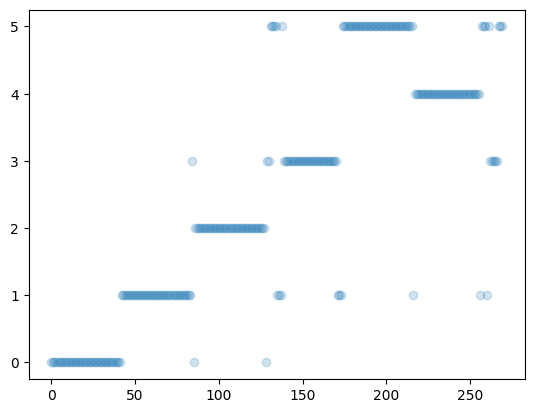

In [88]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(0,len(y_inference_pred)), y_inference_pred, alpha=0.2)

#### Stap 5. Data postprocessing

#### Stap 6. Feedback logica

In [89]:
poses = {0:'crossed arms',
         1:'gestures',
         2:'back',
         3:'hands pockets',
         4:'touching face',
         5:'one leg'}

Pose found: crossed arms with probability: 1.0


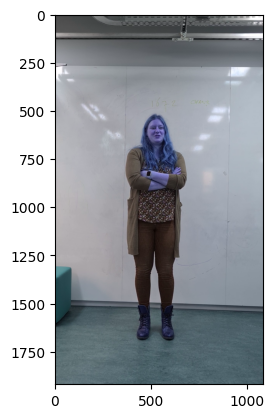

Pose found: gestures with probability: 0.77


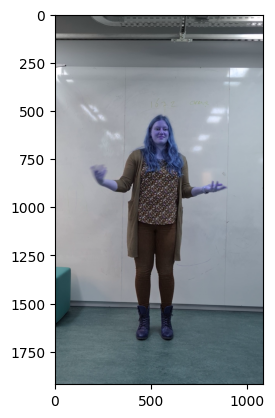

Pose found: back with probability: 0.76


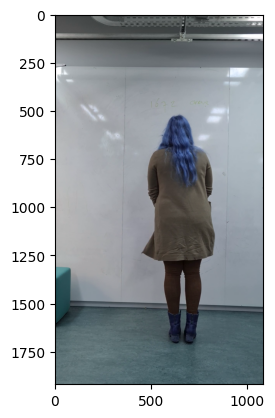

Pose found: hands pockets with probability: 0.71


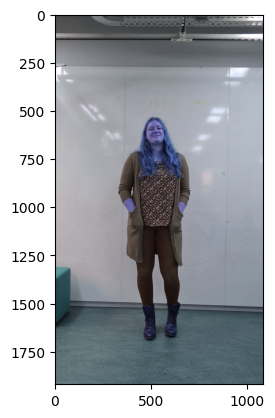

Pose found: one leg with probability: 0.72


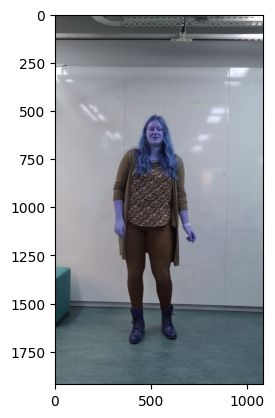

Pose found: touching face with probability: 0.56


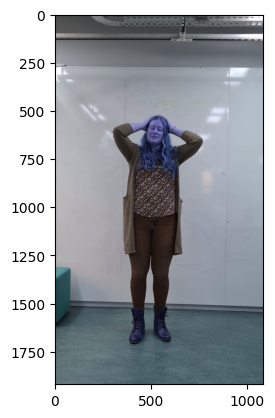

In [94]:
# Deze code kijkt binnen een gegeven aantal frames of een bepaalde pose vaak genoeg voor komt om er feedback over te geven

# Hulpvariabelen voor de loop
i = 0
previous_pose = -1

# Aantal frames waar naar gekeken wordt en de treshold voor het bepalen of een pose vaak genoeg voorgekomen is
number_frames = 10
treshold_frames = 7

# Loop over alle frames in de video
while i < len(y_inference_pred) - number_frames:

    # y_inference_pred bevat alle voorspellingen.
    # Voor de voorspellingen i t/m i+number_frames wordt de modus bepaald: de voorspelling die het vaakst voor komt
    # Als de modus groter dan de treshold is, is er een pose gevonden die vaak genoeg voor komt in deze frames
    if stats.mode(y_inference_pred[i:i+number_frames])[1] > treshold_frames:

        # Als de gevonden pose hetzelfde is als previous_pose, hoeft er niks te gebeuren: dat betekent dat de pose langer dan number_frames aanhoudt
        if stats.mode(y_inference_pred[i:i+number_frames])[0] != previous_pose:

            # previous_pose wordt in dit geval overschreven met de nieuw gevonden pose
            previous_pose = int(stats.mode(y_inference_pred[i:i+number_frames])[0])

            # berekening van de probability van de gevonden pose door te kijken naar de gemiddelde proba uit y_inference_pred_proba
            proba = np.round(y_inference_pred_proba[i:i+number_frames,previous_pose].mean(),2)
            print("Pose found: " + poses[previous_pose] +
                  " with probability: " + str(proba))

            # Ophalen frame om te tonen
            image = Image.fromarray(results_inference[int(analytics_df['frame_number'].loc[i+number_frames//2])].orig_img).convert('RGB')
            plt.imshow(image)
            plt.show()

        i = i + number_frames
    else: i = i + 1